In [3]:
import numpy as np
import math
import matplotlib.pyplot as plt
import pygame

In [4]:
'''ROBOT MODEL'''
class robot_arm_2dof:
    def __init__(self, l):
        self.l = l  # link length
        self.q = np.zeros([2])  # joint position
        self.q2 = np.zeros([2])  # joint position

    # forward kinematics
    def FK(self, q):
        p = np.zeros([2])  # endpoint position
        p[0] = self.l[0] * math.cos(self.q[0]) + self.l[1] * math.cos(self.q[1] + self.q[0])
        p[1] = self.l[0] * math.sin(self.q[0]) + self.l[1] * math.sin(self.q[1] + self.q[0])
        return p

    def FK_DH(self, q):
        p = np.zeros([2])  # endpoint position
        # DH parameter
        alpha = np.zeros([2])
        a = np.zeros([2])
        a[0] = self.l[0]
        a[1] = self.l[1]
        d = np.zeros([2])
        theta = np.zeros([2])
        theta[0] = self.q[0]
        theta[1] = self.q[1]
        A = np.identity(4)
        for i in range(2):
            T_zd = np.array([[1, 0, 0, 0], [0, 1, 0, 0], [0, 0, 1, d[i]], [0, 0, 0, 1]])
            T_ztheta = np.array(
                [[np.cos(theta[i]), -np.sin(theta[i]), 0, 0], [np.sin(theta[i]), np.cos(theta[i]), 0, 0], [0, 0, 1, 0],
                 [0, 0, 0, 1]])
            T_xa = np.array([[1, 0, 0, a[i]], [0, 1, 0, 0], [0, 0, 1, 0], [0, 0, 0, 1]])
            T_xalpha = np.array(
                [[1, 0, 0, 0], [0, np.cos(alpha[i]), -np.sin(alpha[i]), 0], [0, np.sin(alpha[i]), np.cos(alpha[i]), 0],
                 [0, 0, 0, 1]])
            A = A.dot(T_zd.dot(T_ztheta.dot(T_xa).dot(T_xalpha)))
        p = A.dot(np.array([0, 0, 0, 1]))
        return p[0:2]

    # Jacobian matrix
    def Jacobian(self):
        J = np.zeros([2, 2])
        J[0, 0] = self.l[0] * (-math.sin(self.q[0]) - self.l[1] * math.sin(self.q[0] + self.q[1]))
        J[0, 1] = self.l[1] * (-math.sin(self.q[1] + self.q[0]))
        J[1, 0] = self.l[0] * math.cos(self.q[0]) + l[1] * math.cos(self.q[0] + self.q[1])
        J[1, 1] = self.l[1] * (math.cos(self.q[0] + self.q[1]))

        return J

    # inverse kinematics
    def IK_Analytical(self, p):
        q = np.zeros([2])
        r = np.sqrt(p[0] ** 2 + p[1] ** 2)
        q[1] = np.pi - math.acos((self.l[0] ** 2 + self.l[1] ** 2 - r ** 2) / (2 * self.l[0] * self.l[1]))
        q[0] = math.atan2(p[1], p[0]) - math.acos((self.l[0] ** 2 - self.l[1] ** 2 + r ** 2) / (2 * self.l[0] * r))

        return q

    # inverse kinematics
    def IK_Numerical(self, p):
        q_sim = []
        error = p - self.FK(self.q)
        while abs(np.linalg.norm(error)) > 0.0001:
            J = self.Jacobian()
            # print(np.linalg.inv(J))
            self.q = self.q + np.linalg.inv(J).dot(error)
            error = p - self.FK(self.q)
            q_sim.append(self.q)
        return self.q, q_sim

    # state change
    def Init_state(self, q):
        self.q = q

In [81]:
class robotarm_3RP:
    def __init__(self):
        self.q = np.array([np.pi/2,0,0,0])  # joint position
    def FK_SDH(self):
        theta = [np.pi/2 + self.q[0], 0, -np.pi/2+ self.q[2], + self.q[3]]
        d = [0.032, self.q[1] , 0.256, 0]
        a =  [0, 0, -0.03, 0]
        alpha = [-np.pi/2, 0, -np.pi/2, 0]
        A = np.identity(4)
        p = [np.array([0,0,0,1])]
        for i in range(4):
            T_zd = np.array([[1, 0, 0, 0], [0, 1, 0, 0], [0, 0, 1, d[i]], [0, 0, 0, 1]])
            T_ztheta = np.array(
                [[np.cos(theta[i]), -np.sin(theta[i]), 0, 0], 
                 [np.sin(theta[i]), np.cos(theta[i]), 0, 0], 
                 [0, 0, 1, 0],
                 [0, 0, 0, 1]])
            T_xa = np.array([[1, 0, 0, a[i]], 
                             [0, 1, 0, 0], 
                             [0, 0, 1, 0], 
                             [0, 0, 0, 1]])
            T_xalpha = np.array(
                [[1, 0, 0, 0], 
                 [0, np.cos(alpha[i]), -np.sin(alpha[i]), 0], 
                 [0, np.sin(alpha[i]), np.cos(alpha[i]), 0],
                 [0, 0, 0, 1]])
            
            A = A.dot(T_zd.dot(T_ztheta.dot(T_xa).dot(T_xalpha)))
            p.append(A.dot(np.array([0, 0, 0, 1])))
        return p
    
        
    def IK_analytical(self):
        return
    def IK_numerical(self):
        
        return
    def Jacobian(self):
        return

In [82]:
# SIMULATOR
# initialise robot model class
model = robotarm_3RP()
p  = model.FK_SDH()
for i in range(len(p)):
    print(p[i])

[0 0 0 1]
[0.    0.    0.032 1.   ]
[0.    0.    0.032 1.   ]
[-2.95139879e-17 -2.56000000e-01  2.00000000e-03  1.00000000e+00]
[-2.95139879e-17 -2.56000000e-01  2.00000000e-03  1.00000000e+00]


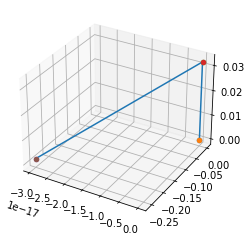

In [83]:
from mpl_toolkits import mplot3d
import matplotlib.pyplot as plt
import numpy as np

ax = plt.axes(projection='3d')
ax.scatter3D(0, 0, 0)
x_values = []
y_values = []
z_values = []
for i in range(len(p)):
    x = p[i][0]
    y = p[i][1] 
    z = p[i][2]
    ax.scatter3D(x, y, z)
    x_values.append(x)
    y_values.append(y)
    z_values.append(z)

ax.plot(x_values,y_values,z_values)



In [69]:
ax.plot(x,y,z)

In [ ]:
ax = plt.axes(projection='3d')
zdata = 15 * np.random.random(100)
xdata = np.sin(zdata) + 0.1 * np.random.randn(100)
ydata = np.cos(zdata) + 0.1 * np.random.randn(100)
ax.scatter3D(xdata, ydata, zdata, c=zdata, cmap='Greens')

In [ ]:
'''SIMULATION'''
# SIMULATION PARAMETERS
dt = 0.5  # intergration step timedt = 0.01 # integration step time
dts = dt * 1  # desired simulation step time (NOTE: it may not be achieved)

# ROBOT PARAMETERS
x0 = 0.0  # base x position
y0 = 0.0  # base y position
l1 = 0.3  # link 1 length
l2 = 0.3  # link 2 length
l = [l1, l2]  # link length

# REFERENCE TRAJETORY
x = 1
y = 1

# SIMULATOR
# initialise robot model class
model = robot_arm_2dof(l)
q_init = [-np.pi, np.pi/2]
model.Init_state(q_init)
p_ref = [0.0, 0.6]  # reference endpoint trajectory
q_IK_numerical, q_sim = model.IK_Numerical(p_ref)
print("iteration for", len(q_sim))
q_IK_analytical = model.IK_Analytical(p_ref)
pr_numerical = model.FK(q_IK_numerical)
# print(q_sim)

In [ ]:
# initialise real-time plot with pygame
def run_game(q_sim):
    pygame.init()  # start pygame
    window = pygame.display.set_mode((800, 600))  # create a window (size in pixels)
    window.fill((255, 255, 255))  # white background
    xc, yc = window.get_rect().center  # window center
    pygame.display.set_caption('robot arm')

    font = pygame.font.Font('freesansbold.ttf', 12)  # printing text font and font size
    text = font.render('robot arm', True, (0, 0, 0), (255, 255, 255))  # printing text object
    textRect = text.get_rect()
    textRect.topleft = (10, 10)  # printing text position with respect to the top-left corner of the window

    clock = pygame.time.Clock()  # initialise clock
    FPS = int(1 / dts)  # refresh rate

    # initial conditions
    state = []  # state vector

    # scaling
    window_scale = 400  # conversion from meters to pixles

    # wait until the start button is pressed
    run = True
    while run:
    # MAIN LOOP
        for i in range(len(q_sim)):
            # update individual link position    
            x1 = l1 * np.cos(q_sim[i][0])
            y1 = l1 * np.sin(q_sim[i][0])
            x2 = x1 + l2 * np.cos(q_sim[i][0] + q_sim[i][1])
            y2 = y1 + l2 * np.sin(q_sim[i][0] + q_sim[i][1])
            # real-time plotting
            window.fill((255, 255, 255))  # clear window
            pygame.draw.circle(window, (0, 255, 0), (int(window_scale * p_ref[0]) + xc, int(-window_scale * p_ref[1]) + yc),
                               10)  # draw reference position

            pygame.draw.lines(window, (0, 0, 255), False, [(window_scale * x0 + xc, -window_scale * y0 + yc),
                                                           (window_scale * x1 + xc, -window_scale * y1 + yc),
                                                           (window_scale * x2 + xc, -window_scale * y2 + yc)], 3)  # draw
            # links
            pygame.draw.circle(window, (0, 0, 0), (int(window_scale * x0) + xc, int(-window_scale * y0) + yc),
                               7)  # draw shoulder / base
            pygame.draw.circle(window, (0, 0, 0), (int(window_scale * x1) + xc, int(-window_scale * y1) + yc),
                               7)  # draw elbow
            pygame.draw.circle(window, (255, 0, 0), (int(window_scale * x2) + xc, int(-window_scale * y2) + yc),
                               5)  # draw hand / endpoint
            text = font.render("FPS = " + str(round(clock.get_fps())), True, (0, 0, 0), (255, 255, 255))
            window.blit(text, textRect)
            pygame.display.flip()  # update display
            clock.tick(FPS)  # try to keep it real time with the desired step time 
        run = False
    pygame.quit()

In [ ]:
run_game(q_sim)